In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.17 GB
Available RAM  : 25.95 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [5]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

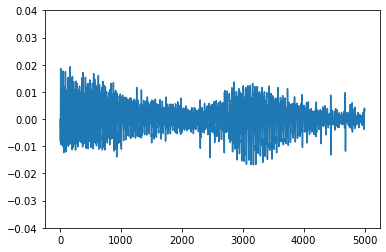

In [6]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [8]:
# list(model.children())[0]

In [9]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [10]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (inf --> 14.749696).  Saving model ...
Epoch 0: train_acc: 89.09% loss: 0.128,  val_loss: 14.750 val_acc: 40.25%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (14.749696 --> 10.015483).  Saving model ...
Epoch 1: train_acc: 92.96% loss: 0.090,  val_loss: 10.015 val_acc: 59.52%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (10.015483 --> 2.937930).  Saving model ...
Epoch 2: train_acc: 93.94% loss: 0.058,  val_loss: 2.938 val_acc: 45.95%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 3: train_acc: 94.71% loss: 0.042,  val_loss: 9.767 val_acc: 40.33%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (2.937930 --> 1.085934).  Saving model ...
Epoch 4: train_acc: 95.21% loss: 0.048,  val_loss: 1.086 val_acc: 63.32%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 5: train_acc: 95.67% loss: 0.038,  val_loss: 2.184 val_acc: 59.62%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 6: train_acc: 96.01% loss: 0.073,  val_loss: 31.261 val_acc: 47.63%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 7: train_acc: 96.29% loss: 0.026,  val_loss: 6.373 val_acc: 59.61%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (1.085934 --> 0.422601).  Saving model ...
Epoch 8: train_acc: 96.69% loss: 0.015,  val_loss: 0.423 val_acc: 86.30%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 9: train_acc: 96.99% loss: 0.045,  val_loss: 1.594 val_acc: 77.40%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 10: train_acc: 97.24% loss: 0.014,  val_loss: 15.327 val_acc: 51.61%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 11: train_acc: 97.11% loss: 0.019,  val_loss: 2.115 val_acc: 60.39%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 1.0000e-03.
Epoch 12: train_acc: 97.65% loss: 0.083,  val_loss: 6.456 val_acc: 59.52%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.422601 --> 0.098924).  Saving model ...
Epoch 13: train_acc: 98.41% loss: 0.011,  val_loss: 0.099 val_acc: 92.96%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.098924 --> 0.051856).  Saving model ...
Epoch 14: train_acc: 98.93% loss: 0.016,  val_loss: 0.052 val_acc: 96.76%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.051856 --> 0.004113).  Saving model ...
Epoch 15: train_acc: 99.11% loss: 0.014,  val_loss: 0.004 val_acc: 97.06%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 16: train_acc: 99.25% loss: 0.003,  val_loss: 0.005 val_acc: 97.01%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 17: train_acc: 99.43% loss: 0.005,  val_loss: 0.114 val_acc: 91.89%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 18: train_acc: 99.56% loss: 0.004,  val_loss: 0.345 val_acc: 90.59%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.004113 --> 0.003000).  Saving model ...
Epoch 19: train_acc: 99.62% loss: 0.001,  val_loss: 0.003 val_acc: 96.02%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 20: train_acc: 99.72% loss: 0.003,  val_loss: 0.004 val_acc: 97.35%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 21: train_acc: 99.75% loss: 0.006,  val_loss: 0.020 val_acc: 96.83%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 22: train_acc: 99.77% loss: 0.001,  val_loss: 0.171 val_acc: 90.74%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Epoch 23: train_acc: 99.81% loss: 0.001,  val_loss: 0.075 val_acc: 96.53%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 24: train_acc: 99.81% loss: 0.001,  val_loss: 0.006 val_acc: 97.24%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.003000 --> 0.002323).  Saving model ...
Epoch 25: train_acc: 99.88% loss: 0.053,  val_loss: 0.002 val_acc: 97.29%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 26: train_acc: 99.87% loss: 0.031,  val_loss: 0.007 val_acc: 97.22%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.002323 --> 0.001624).  Saving model ...
Epoch 27: train_acc: 99.92% loss: 0.002,  val_loss: 0.002 val_acc: 97.29%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Validation loss decreased (0.001624 --> 0.001112).  Saving model ...
Epoch 28: train_acc: 99.91% loss: 0.009,  val_loss: 0.001 val_acc: 97.30%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 29: train_acc: 99.91% loss: 0.044,  val_loss: 0.002 val_acc: 97.34%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 30: train_acc: 99.92% loss: 0.005,  val_loss: 0.002 val_acc: 97.37%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 31: train_acc: 99.93% loss: 0.003,  val_loss: 0.007 val_acc: 97.27%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch    33: reducing learning rate of group 0 to 1.0000e-05.
Epoch 32: train_acc: 99.91% loss: 0.001,  val_loss: 0.005 val_acc: 97.27%


Training..	:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 33: train_acc: 99.93% loss: 0.003,  val_loss: 0.003 val_acc: 97.38%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 87.61it/s] 

Epoch 34: train_acc: 99.94% loss: 0.002,  val_loss: 0.003 val_acc: 97.42%


## Testing

### testing on datasets with same conditions

In [41]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [42]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, loader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

In [43]:
test(model,test_dataloader)

Testing..	: 100%|██████████| 418/418 [00:03<00:00, 136.69it/s]

91.58567583732058


In [19]:
@torch.no_grad()
def get_all_preds(model, loader):
#     model = model.to('cuda', dtype=torch.float)
    model.eval()

    results = {}
    results['preds'] = torch.tensor([])
    results['fnames'] = ()
    results['labels'] = torch.tensor([])
    results['idx'] = torch.tensor([])

    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)

        results['fnames'] += path_batch
        results['labels'] = torch.cat( (results['labels'], y_batch), dim=0)
        results['idx'] = torch.cat( (results['idx'], idx_batch), dim=0)

        preds = model(x_batch.float())
        results['preds'] = torch.cat(
            (results['preds'], preds)
            ,dim=0
        )
    return results

def softmax_out(x):
    return np.argmax(F.softmax(x.reshape(1,-1), dim=1), axis=1).tolist()[0]

### testing on ALL available datasets (collected with the same sensor)

In [20]:
ds1 = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds2 = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds3 = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds4 = WingbeatsDataset(dsname="Melanogaster_RL/W", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))

ds5 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds6 = WingbeatsDataset(dsname="Suzukii_RL/X", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 407 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 742 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [38]:
dslist = [ds1, ds2, ds3, ds4] # ALL_ΜEBIOS

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	:   0%|          | 0/398 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [22]:
dslist = [ds1, ds2, ds3, ds4, ds5, ds6] # ALL_HERENT + ALL_MEBIOS

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 815/815 [00:05<00:00, 153.92it/s]

92.6648773006135


In [23]:
dslist = [ds1, ds2] # ONLY_MEBIOS (summer - suz_rl)

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 380/380 [00:02<00:00, 138.77it/s]

93.82401315789474


In [24]:
dslist = [ds3, ds4] # ONLY_MEBIOS (autumn - mel_xw)

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 18/18 [00:00<00:00, 30.89it/s]

88.10763888888889


In [44]:
model = model.to('cpu', dtype=torch.float)

# dslist = [ds1, ds2, ds3, ds4, ds5, ds6]
# test_dataset = ConcatDataset(dslist)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

results = get_all_preds(model, test_dataloader)



results['preds_labels'] = list(map(softmax_out, results['preds']))

100%|██████████| 418/418 [01:23<00:00,  5.01it/s]


In [45]:
# np.argmax(results['preds'],axis=1)

In [46]:
df = pd.DataFrame(results)
df['humidity'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-1][:-4]).astype(float).values
df['temperature'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-3]).astype(float).values
df.sample(3)

,preds,fnames,labels,idx,preds_labels,humidity,temperature
866,"(tensor(10.1213), tensor(-10.2252))",/home/kalfasyan/data/wingbeats/Melanogaster_RL/Y/D_20_11_12_14_27_29/F201112_144626_151_G_050_T_22.5_H_2.3.wav,0.0,866.0,0,2.3,22.5
25525,"(tensor(-10.9056), tensor(10.4003))",/home/kalfasyan/data/wingbeats/Suzukii_RL/X/D_21_01_22_11_41_12/F210122_124307_008_G_050_T_21.8_H_26.7.wav,1.0,13522.0,1,26.7,21.8
24344,"(tensor(-5.5960), tensor(5.1210))",/home/kalfasyan/data/wingbeats/Suzukii_RL/X/D_21_01_20_21_25_11/F210120_215648_173_G_050_T_21.8_H_20.4.wav,1.0,12341.0,1,20.4,21.8


## Plotting

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
ticklabels = ['Melanogaster','Suzukii']

True vs Predicted


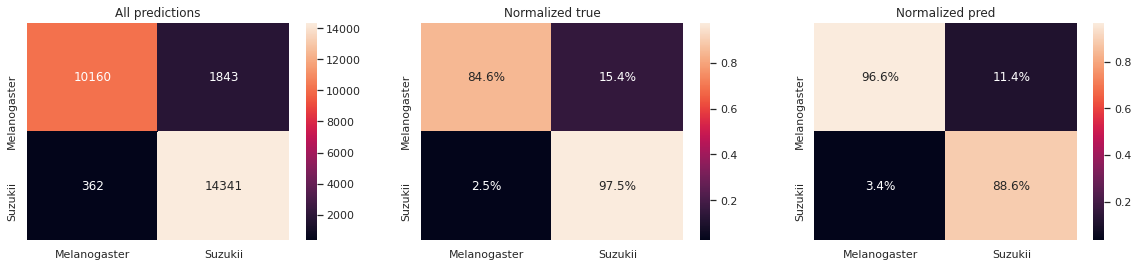

In [48]:
plt.figure(figsize=(20,4));
print("True vs Predicted")
plt.subplot(1,3,1); 
plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,2); 
plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,3); 
plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);

True vs Predicted


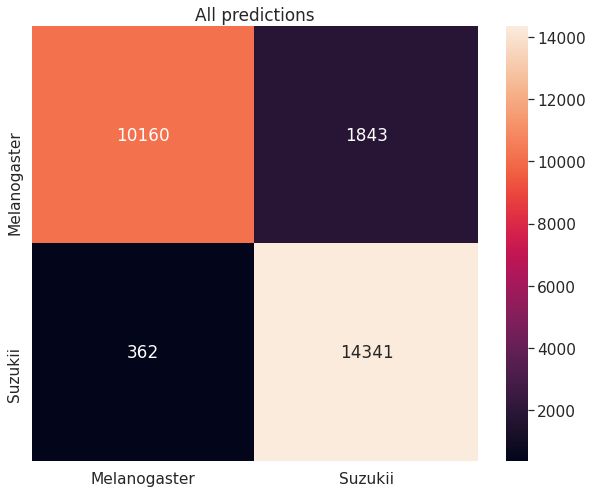

In [49]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
print("True vs Predicted")
plt.subplot(1,3,1); 
plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_all.png', bbox_inches='tight', format='png')

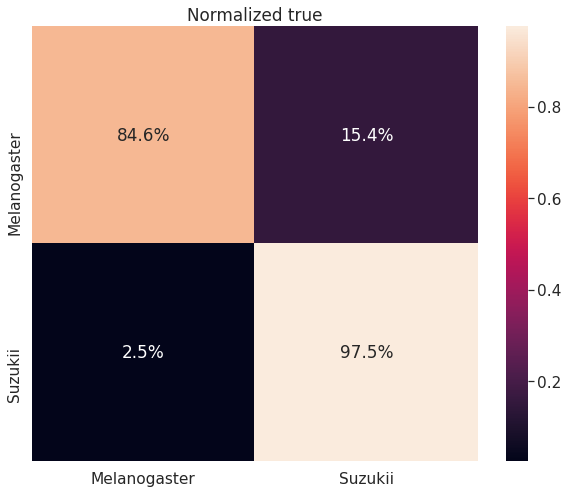

In [50]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
plt.subplot(1,3,1); 

plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_truenorm.png', bbox_inches='tight', format='png')

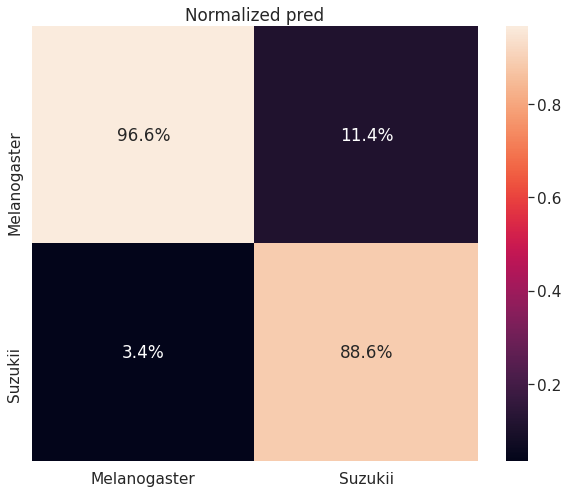

In [51]:
plt.figure(figsize=(34,8));
sns.set(font_scale=1.4)
plt.subplot(1,3,1); 
plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.savefig('/home/kalfasyan/Dropbox/to_send/cm_prednorm.png', bbox_inches='tight', format='png')

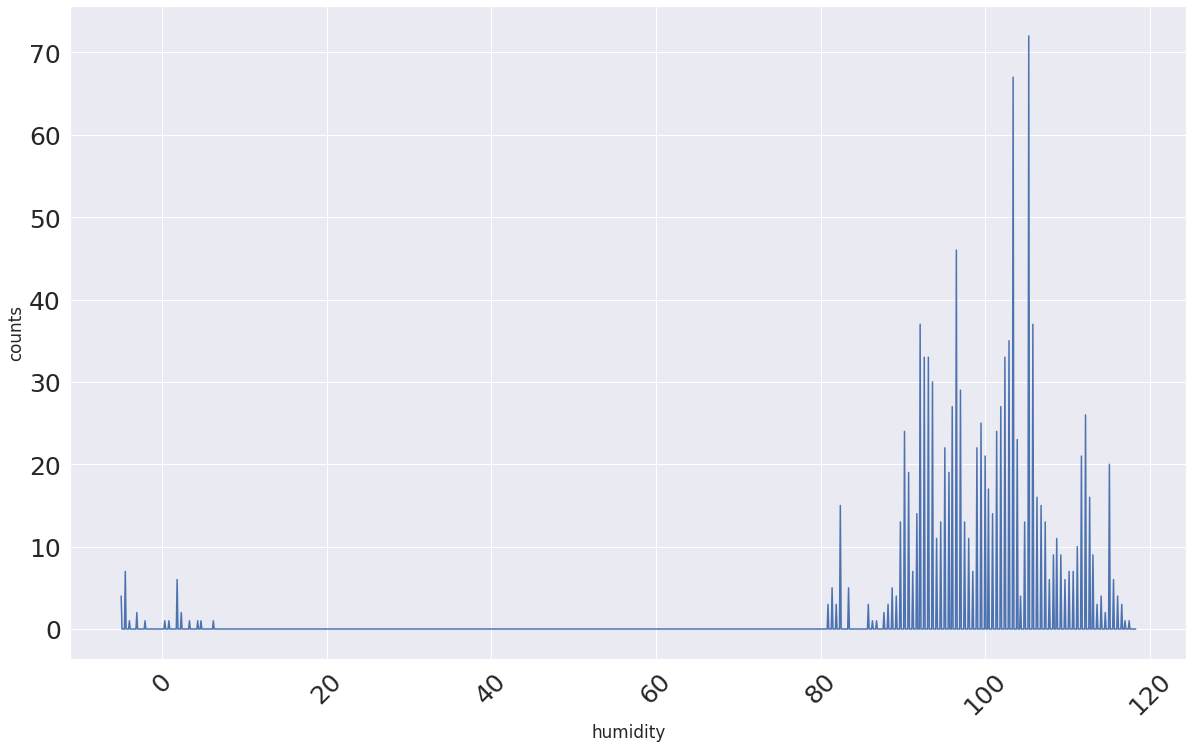

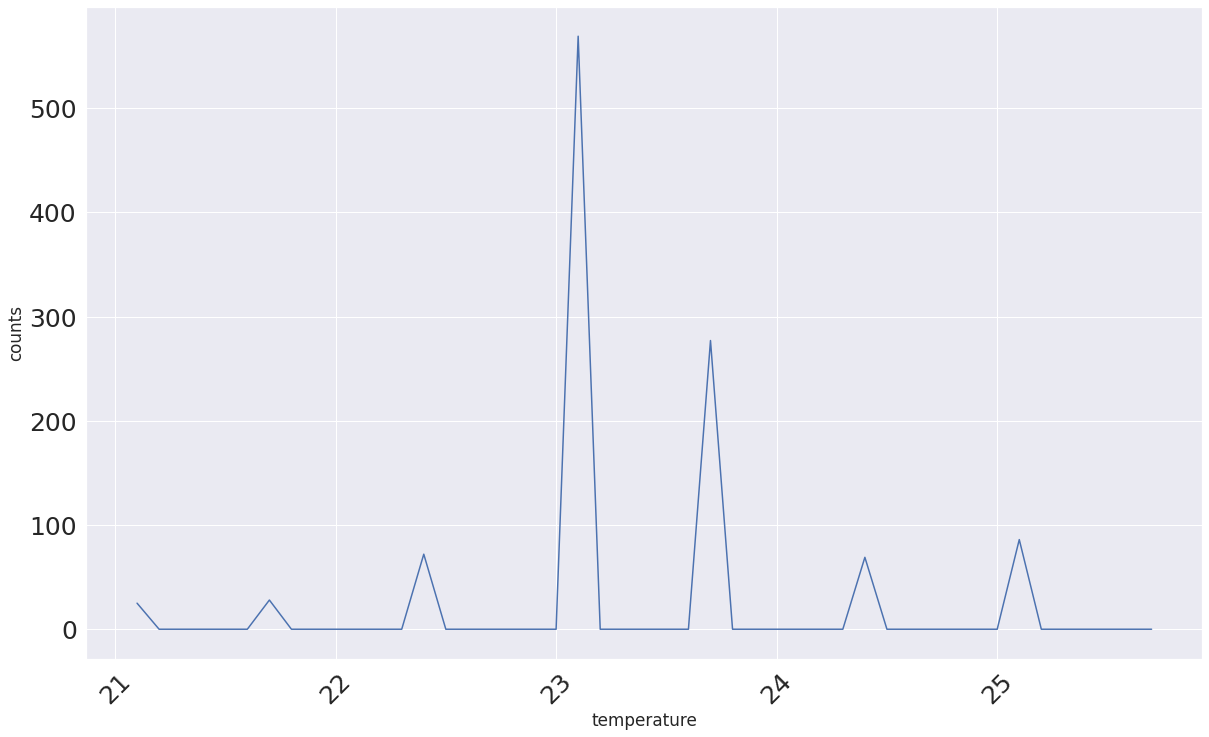

In [32]:
from utils import np_hist
plt.figure(figsize=(20,12))
np_hist(df, 'humidity', fs=25)
plt.figure(figsize=(20,12))
np_hist(df, 'temperature', fs=25)